In [1]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-zsg09syv
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-zsg09syv
  Created wheel for pyFTS: filename=pyFTS-1.6-py3-none-any.whl size=217118 sha256=a8079d413bdeabcc3f41396a6e652c88b4d4c1bd2a177b5d65ff99bb44de07b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-52_ukfms/wheels/30/23/2b/2e10c811e284f08e37b5f6d6320e78bade4dd580081288f61a
Successfully built pyFTS


In [2]:
pip install SimpSOM

  Created wheel for SimpSOM: filename=SimpSOM-1.3.4-py3-none-any.whl size=17088 sha256=750597475d5b91e6a5da9dc037c059ec3458748a9ddae593b082f11fde7a306f
  Stored in directory: /root/.cache/pip/wheels/22/93/66/28200809b28a3685b5040db97cbc27ddd8b1a6372101244102
Successfully built SimpSOM


# **External libraries import**

* Load two time-series of ticker symbols, the NASDAQ and the S&P 500 indices, over time and forecast them using Song and Chissom's 1993 algorithm.

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "17"

* Define a first-order differencing operation for preprocessing.

In [4]:
from pyFTS.common import Transformations

tdiff = Transformations.Differential(1)

* Both datasets, the entries in datasets dictionary, are vectors of roughly 4,000 scalar values.
* Take about 50% of these points for training, and set this as a
constant.

In [5]:
from pyFTS.data import NASDAQ, SP500

datasets = {
    "SP500": SP500.get_data()[11500:16000],
    "NASDAQ": NASDAQ.get_data()
}

train_split = 2000

In [6]:
datasets["NASDAQ"]

array([2373.61, 2434.87, 2597.32, ..., 5215.29, 5226.75, 5210.88])

* Plot time-series and the transformation.

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


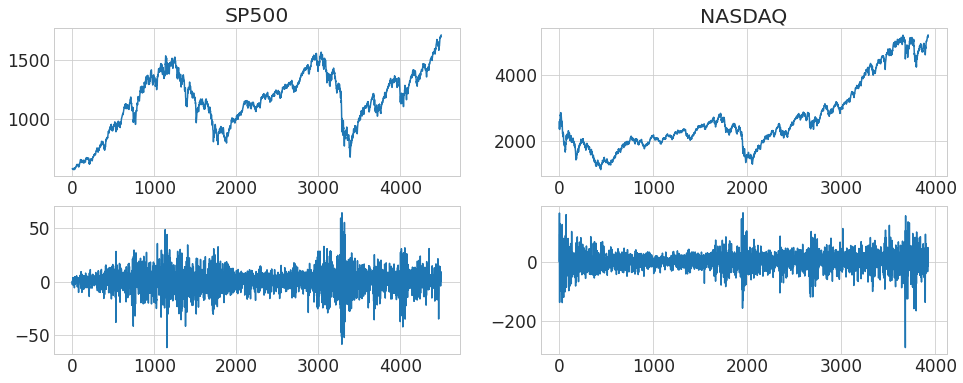

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[16, 6])

for count, (dataset_name, dataset) in enumerate(datasets.items()):
    dataset_diff = tdiff.apply(dataset)

    ax[0][count].plot(dataset)
    ax[1][count].plot(dataset_diff)
    ax[0][count].set_title(dataset_name)

# **Statistics**

In [8]:
from statsmodels.tsa.stattools import adfuller

rows = []

for count, (dataset_name, dataset) in enumerate(datasets.items()):
    row = [dataset_name]
    result = adfuller(dataset)
    row.extend([result[0],result[1]])
    row.extend([value for key, value in result[4].items()])
    rows.append(row)
    
pd.DataFrame(rows, columns=['Dataset','ADF Statistic','p-value','Cr. Val. 1%','Cr. Val. 5%','Cr. Val. 10%'])

Dataset  ADF Statistic   p-value  Cr. Val. 1%  Cr. Val. 5%  Cr. Val. 10%
0   SP500      -1.747171  0.406987    -3.431811    -2.862186     -2.567114
1  NASDAQ       0.476224  0.984132    -3.432022    -2.862279     -2.567163

* The next step is training models for the two transformed (differenced) timeseries.

In [9]:
from pyFTS.models import song
from pyFTS.partitioners import Grid

models = {}

for count, (dataset_name, dataset) in enumerate(datasets.items()):
    partitioner_diff = Grid.GridPartitioner(data=dataset, npart=15, transformation=tdiff)
    model = song.ConventionalFTS(partitioner=partitioner_diff)
    model.name = dataset_name
    model.append_transformation(tdiff)
    model.fit(dataset[:train_split], order=1)
    models[dataset_name] = model

* Plot forecasts from the two models.

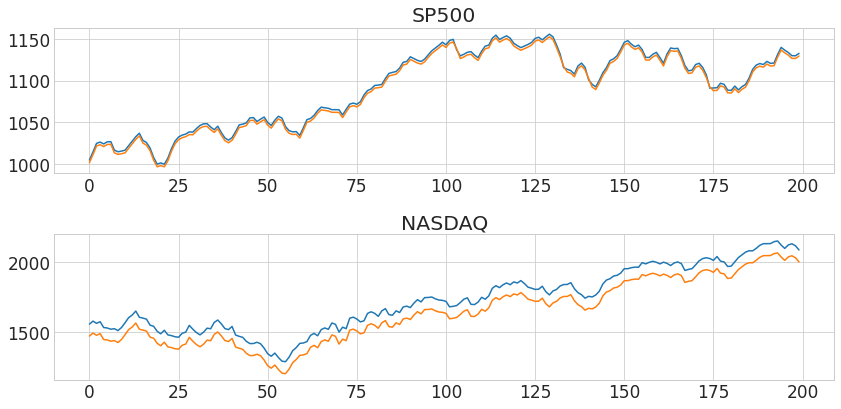

In [10]:
_, ax = plt.subplots(nrows=2, ncols=1, figsize=[12, 6])

for count, (dataset_name, dataset) in enumerate(datasets.items()):
    ax[count].plot(dataset[train_split:train_split+200])
    model = models[dataset_name]
    forecasts = model.predict(dataset[train_split:train_split+200], steps_ahead=1)
    ax[count].plot(forecasts)
    ax[count].set_title(dataset_name)
    
plt.tight_layout()

* PyFTS has a convenience function to extract RMSE, MAPE, and finally, Theil's U, a measure of correlation. 

In [11]:
from pyFTS.benchmarks import Measures

rows = []

for count, (dataset_name, dataset) in enumerate(datasets.items()):
    row = [dataset_name]
    test = dataset[train_split:train_split+200]
    model = models[dataset_name]
    row.extend(Measures.get_point_statistics(test, model))
    rows.append(row)
    
pd.DataFrame(rows,columns=["Dataset", "RMSE", "MAPE", "Theil's U"]).set_index("Dataset")

RMSE  MAPE  Theil's U
Dataset                        
SP500     6.76  0.52       1.22
NASDAQ   90.85  5.14       3.79

# **Residual Analysis**

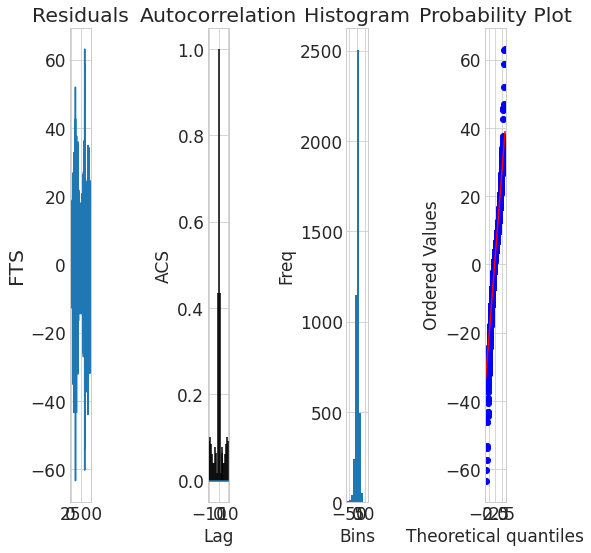

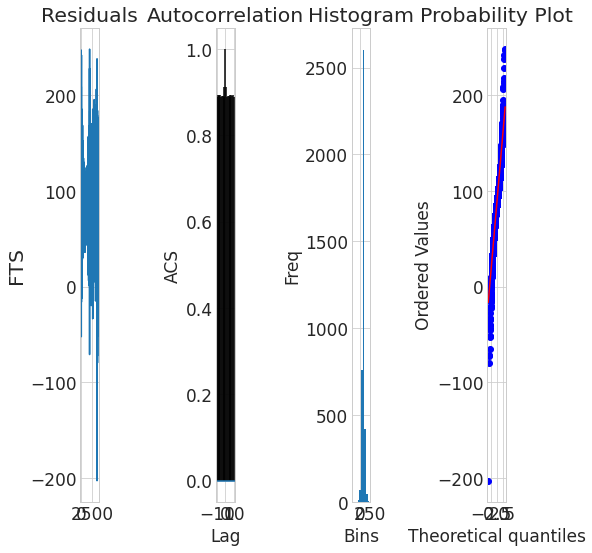

In [12]:
from pyFTS.benchmarks import ResidualAnalysis as ra

for count, (dataset_name, dataset) in enumerate(datasets.items()):
    model = models[dataset_name]
    ra.plot_residuals_by_model(dataset, [model])